# Cijfers
## Details
> Het  gebruik  van  cijfers  in  koppen  maakt  de  inhoud van het artikel voorspelbaar voor de lezers. Het geeft hen  zekerheid  waardoor  ze  weten  wat  ze  kunnen verwachten. Cijfers kunnen krantenkoppen interessanter  maken,  vooral  wanneer  het  gaat  om grote getallen (1). Ook kunnen cijfers inspelen op de gevoelens van mensen door bijvoorbeeld de leeftijd weer tegeven (2).
## Example
> (1) Iedereen dacht dat 313kinderen ziek werden door zijn lasagne, maar dat klopt niet: "Wat dan wél?"(2) Kranige  oma (93)bewijst  dat  er  op  angst overwinnen geen leeftijd staat

## Data

In [1]:
from util import get_cls_train_test

train_x, train_y, test_x, test_y = get_cls_train_test("Cijfers")
train_y.value_counts()

0    559
1    122
Name: Cijfers, dtype: int64

## Approach 1: Tf-idf
This will probably overfit on the numbers we've already seen

f-score: 0.4857142857142858
Confusion matrix: (TP: 175, FP: 6, FN: 30, TN: 17)
Accuracy=84.21% (192/228)


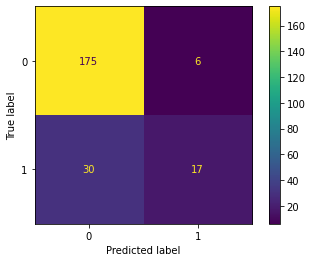

In [2]:
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

from util import fit_predict_evaluate

model = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('resampler', SMOTETomek(random_state=0)),
    ('classifier', svm.LinearSVC(random_state=0))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

In [3]:
from util import show_most_informative_features
show_most_informative_features(model)

2.7186           jaar    -0.7803           maar
2.2859            000    -0.6940           deze
2.1316           euro    -0.6653         meghan
1.5962         graden    -0.6162          heeft
1.5491             24    -0.5948          vrouw
1.4937            eén    -0.5763            dat
1.4067          meter    -0.5753           zien
1.3941             al    -0.5172           weer
1.3424        miljoen    -0.5133           gaat
1.3315          enige    -0.5102         gedaan


I didn't expect words like "jaar", "euro" or "graden" here, but it's quite a smart solution to the problem. Also "000" is interesting, since it get's seen as a seperate token in large number (because a "." means new token, e.g. 7.000.000 -> "7", "000" and "000").

## Approach 2: Char grams
Since a lot of number (e.g. "zevenhonderddrieëntwintig") consist of existing number, we can try to use char grams to predict whether there is a number. "Char-wb" stays between word boundries.

f-score: 0.5217391304347826
Confusion matrix: (TP: 177, FP: 4, FN: 29, TN: 18)
Accuracy=85.53% (195/228)


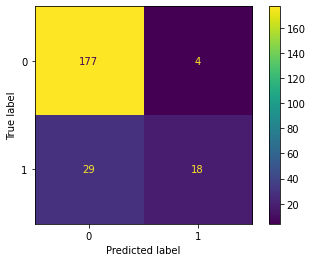

In [4]:
model = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer="char_wb", ngram_range=(1, 6))), # 2 e.g. -ig, 6 e.g. twaalf; 1 e.g. 1 (the number 1)
    ('resampler', SMOTETomek(random_state=0)),
    ('classifier', svm.LinearSVC(random_state=0))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

In [6]:
show_most_informative_features(model, n=20)

2.6915              0    -0.5970             t 
1.6069              1    -0.5216             on
1.5240             0     -0.5142             ns
1.4168              2    -0.4811              o
1.3265             00    -0.4747              z
1.2748                   -0.4474              r
1.2497              (    -0.4133              '
1.2497              (    -0.4017             he
1.2497              )    -0.3977              g
1.1836              3    -0.3894             du
1.1315             )     -0.3822              n
1.0214              1    -0.3695            ns 
0.9975              2    -0.3679             sc
0.9817              4    -0.3666             ck
0.8864              5    -0.3600           maar
0.8856            00     -0.3574          maar 
0.8130           jaar    -0.3486            et 
0.8087           jaar    -0.3470              e
0.8022              7    -0.3466            sch
0.7967            jaa    -0.3442           maar


Previousely seen digits seem important. I have no explanation for the characters on the negative side. "Jaar" also stays something with a clear positive impact.

### Approach 3: Own function
Our function from earlier checks whether there is any digit or whether it contains a number as text (based on a list of known numbers). However as warned for earlier, this kind of functions are prone to overfitting, but I want to test it anyway to compare it with our char-gram model.

In [7]:
def contains_number_word(headline):
    # Note: I didn't write this entire list all by myself, it was suggested by GitHub Co-Pilot
    numbers = ["één", "twee", "drie", "vier", "vijf", "zes", "zeven", "acht", "negen", "tien", "elf", "twaalf",
               "dertien", "veertien", "vijftien", "zestien", "zeventien", "achttien", "negentien", "twintig", "dertig",
               "veertig", "vijftig", "zestig", "zeventig", "tachtig", "negentig", "honderd", "duizend", "miljoen",
               "miljard", "biljoen", "biljard",
               "triljoen"]  #, "triljard", "quadriljoen", "quadriljard", "quintiljoen", "quintiljard", "sextiljoen", "sextiljard", "septiljoen", "septiljard", "octiljoen", "octiljard", "noniljoen", "noniljard", "deciljoen", "deciljard", "undeciljoen", "undeciljard", "duodeciljoen", "duodeciljard", "tredeciljoen", "tredeciljard", "quattuordeciljoen", "quattuordeciljard", "quindeciljoen", "quindeciljard", "sexdeciljoen", "sexdeciljard", "septendeciljoen", "septendeciljard", "octodeciljoen", "octodeciljard", "novemdeciljoen", "novemdeciljard", "vigintiljoen", "vigintiljard", "unvigintiljoen", "unvigintiljard", "duovigintiljoen", "duovigintiljard", "trevigintiljoen", "trevigintiljard", "quattuorvigintiljoen", "quattuorvigintiljard", "quinquavigintiljoen", "quinquavigintiljard", "sexvigintiljoen", "sexvigintiljard", "septenvigintiljoen",
    headline = headline.lower().split()
    for number in numbers:
        if number in headline:
            return True
    return False


def contains_number(headline):
    # TODO? This doesn't check numbers written as text (e.g. "five")
    return any(char.isdigit() for char in headline)  # or contains_number_word(headline)

def contains_number_or_number_word(headline):
    return contains_number(headline) or contains_number_word(headline)

print(contains_number(
    "Iedereen dacht dat 313 kinderen ziek werden door zijn lasagne, maar dat klopt niet: \"Wat dan wél?\""))
print(contains_number("Kranige oma (93) bewijst dat er op angst overwinnen geen leeftijd staat"))

True
True


f-score: 0.8
Confusion matrix: (TP: 162, FP: 19, FN: 3, TN: 44)
Accuracy=90.35% (206/228)


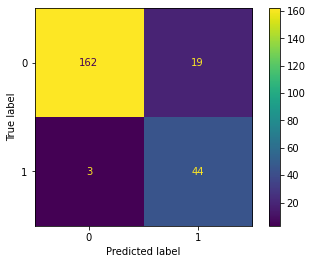

In [8]:
from util import print_evaluation
predict = test_x.apply(contains_number_or_number_word)
print_evaluation(test_y, predict)

This gives the best results.

## Approach 2: SpaCy
SpaCy was excellent in detecting proper nouns. We might be able to check for two consequtive proper nouns.

In [6]:
import spacy
from pprint import pprint

nlp = spacy.load('nl_core_news_sm')
pprint([(x.text, x.pos_, x.dep_, [(x.text, x.dep_) for x in list(x.children)]) for x in nlp(u"Zanger Arno Hintjes overleden")])

[('Zanger', 'NOUN', 'ROOT', []),
 ('Arno', 'PROPN', 'amod', []),
 ('Hintjes', 'NOUN', 'obj', [('Arno', 'amod')]),
 ('overleden', 'VERB', 'ROOT', [('Hintjes', 'obj')])]


Quite strange "Hintjes" is not a proper noun.

In [7]:
pprint([(x.text, x.pos_, x.text) for x in nlp(u"Meghan Markles papa in tranen toen prins Charles zijn dochter weggaf: \"Ik wenste dat ik daar was\"")])

[('Meghan', 'PROPN', 'Meghan'),
 ('Markles', 'PROPN', 'Markles'),
 ('papa', 'VERB', 'papa'),
 ('in', 'ADP', 'in'),
 ('tranen', 'NOUN', 'tranen'),
 ('toen', 'SCONJ', 'toen'),
 ('prins', 'NOUN', 'prins'),
 ('Charles', 'PROPN', 'Charles'),
 ('zijn', 'PRON', 'zijn'),
 ('dochter', 'NOUN', 'dochter'),
 ('weggaf', 'VERB', 'weggaf'),
 (':', 'PUNCT', ':'),
 ('"', 'PUNCT', '"'),
 ('Ik', 'PRON', 'Ik'),
 ('wenste', 'VERB', 'wenste'),
 ('dat', 'SCONJ', 'dat'),
 ('ik', 'PRON', 'ik'),
 ('daar', 'ADV', 'daar'),
 ('was', 'VERB', 'was'),
 ('"', 'PUNCT', '"')]


In [8]:
def contains_consecutive_pronouns(headline):
    previous_propn = False
    for x in nlp(headline):
        if x.pos_ == 'PROPN' and previous_propn:
            return True
        previous_propn = x.pos_ == 'PROPN'
    return False

print(contains_consecutive_pronouns(u"Meghan Markles papa in tranen toen prins Charles zijn dochter weggaf"))
print(contains_consecutive_pronouns(u"Meghans papa in tranen toen prins Charles zijn dochter weggaf"))

True
False


f-score: 0.5245901639344263
Confusion matrix: (TP: 183, FP: 26, FN: 3, TN: 16)
Accuracy=87.28% (199/228)


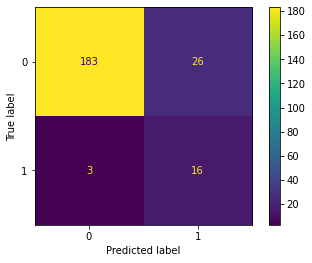

In [9]:
import numpy as np
from util import print_evaluation

prediction = np.vectorize(contains_consecutive_pronouns)(test_x)
print_evaluation(test_y, prediction)

 A slightly worse accuracy, but the f-score is already better.

In [10]:
# False positives
prediction = train_x.apply(contains_consecutive_pronouns)
train_x[(prediction != train_y) & (prediction == 1)][:5]

Test      
102   270     Hij is de beroemdste peuter van België, maar w...
733   1834    "Zo ga ik beroemd worden": cliniclown Kevin (3...
3     4       Maandag drukste dag van het jaar op Brussels A...
465   1172    Club Brugge haalt Nederlands talent met straff...
495   1237    Man zwemt in zes maanden en in 9.000 kilometer...
Name: Headline, dtype: object

Things like "Manneke Pis", "Club Brugge", "Stille Ocean" are false positives. Let's see if we can solve this by combining this function with Tf-Idf.

## Approach 3: Tf-Idf + Consecutive proper nouns (SpaCy)

f-score: 0.6666666666666666
Confusion matrix: (TP: 200, FP: 9, FN: 5, TN: 14)
Accuracy=93.86% (214/228)


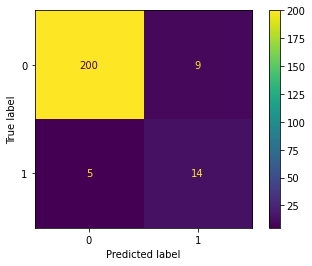

In [11]:
from sklearn.pipeline import FeatureUnion
from util import FunctionTransformer
model = Pipeline([
    ('union', FeatureUnion([
        ('vectorizer', TfidfVectorizer(ngram_range=(1, 1))),
        ('consecutive_pronouns', FunctionTransformer(contains_consecutive_pronouns))
    ])),
    ('resampler', SMOTETomek(random_state=0)),
    ('classifier', svm.LinearSVC(random_state=0))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

We're getting a better accuracy and a better f-score now.

In [12]:
show_most_informative_features(model, vectorizer=model.named_steps['union'].transformer_list[0][1])

1.3005         zitten    -1.1260           rode
1.0842           demi    -0.7400        duivels
1.0842         lovato    -0.7092            uit
1.0787         hilton    -0.6527           club
1.0787          paris    -0.6261           maar
0.8728           niet    -0.6123           voor
0.8459    belangrijke    -0.6060             op
0.8459     executeren    -0.5970             ik
0.8325            mol    -0.5704     temptation
0.8307           marc    -0.5687          trump


Some words related to "Rode Duivels" (rode, duivels, doelman ...). Let's try 2-grams again:

f-score: 0.5714285714285714
Confusion matrix: (TP: 193, FP: 16, FN: 5, TN: 14)
Accuracy=90.79% (207/228)


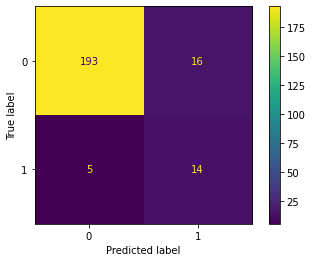

In [14]:
model = Pipeline([
    ('union', FeatureUnion([
        ('vectorizer', TfidfVectorizer(ngram_range=(2, 2))),
        ('consecutive_pronouns', FunctionTransformer(contains_consecutive_pronouns))
    ])),
    ('resampler', SMOTETomek(random_state=0)),
    ('classifier', svm.LinearSVC(random_state=0))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

In [15]:
show_most_informative_features(model, vectorizer=model.named_steps['union'].transformer_list[0][1])

1.0833    demi lovato    -0.8996   rode duivels
0.9351   paris hilton    -0.6517        de rode
0.7770      erpe mere    -0.4987          is de
0.7770honderden treinreizigers    -0.4861    club brugge
0.7770        in erpe    -0.4731          op de
0.7770treinreizigers zitten    -0.4036         uit de
0.7770    zitten vast    -0.3973temptation island
0.7569     terug naar    -0.3883        met een
0.6765    in kritieke    -0.3805   test aankoop
0.6765kritieke toestand    -0.3659          in de


Still stragne results, I would've expected way more firt+lastname pairs with a positive impact. I did expect words like "rode duivels", "club brugge", "temptation island" and "test aankoop" with a negative impact, as it's now the case.